In [1]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 36.4MB/s 
     |████████████████████████████████| 655kB 41.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/"

In [0]:
from argparse import Namespace
from pathlib import Path
import torch
import logging
import json
import random
import numpy as np
from collections import namedtuple
from tempfile import TemporaryDirectory

from torch.utils.data import DataLoader, Dataset, RandomSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from pytorch_pretrained_bert.modeling import BertForPreTraining
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

In [0]:
InputFeatures = namedtuple("InputFeatures", "input_ids input_mask segment_ids lm_label_ids is_next")

log_format = '%(asctime)-10s: %(message)s'
logging.basicConfig(level=logging.INFO, format=log_format)

In [0]:
def convert_example_to_features(example, tokenizer, max_seq_length):
    tokens = example["tokens"]
    segment_ids = example["segment_ids"]
    is_random_next = example["is_random_next"]
    masked_lm_positions = example["masked_lm_positions"]
    masked_lm_labels = example["masked_lm_labels"]

    assert len(tokens) == len(segment_ids) <= max_seq_length  # The preprocessed data should be already truncated
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    masked_label_ids = tokenizer.convert_tokens_to_ids(masked_lm_labels)

    input_array = np.zeros(max_seq_length, dtype=np.int)
    input_array[:len(input_ids)] = input_ids

    mask_array = np.zeros(max_seq_length, dtype=np.bool)
    mask_array[:len(input_ids)] = 1

    segment_array = np.zeros(max_seq_length, dtype=np.bool)
    segment_array[:len(segment_ids)] = segment_ids

    lm_label_array = np.full(max_seq_length, dtype=np.int, fill_value=-1)
    lm_label_array[masked_lm_positions] = masked_label_ids

    features = InputFeatures(input_ids=input_array,
                             input_mask=mask_array,
                             segment_ids=segment_array,
                             lm_label_ids=lm_label_array,
                             is_next=is_random_next)
    return features


class PregeneratedDataset(Dataset):
    def __init__(self, training_path, epoch, tokenizer, num_data_epochs, reduce_memory=False):
        self.vocab = tokenizer.vocab
        self.tokenizer = tokenizer
        self.epoch = epoch
        self.data_epoch = epoch % num_data_epochs
        data_file = training_path / f"epoch_{self.data_epoch}.json"
        metrics_file = training_path / f"epoch_{self.data_epoch}_metrics.json"
        assert data_file.is_file() and metrics_file.is_file()
        metrics = json.loads(metrics_file.read_text())
        num_samples = metrics['num_training_examples']
        seq_len = metrics['max_seq_len']
        self.temp_dir = None
        self.working_dir = None
        if reduce_memory:
            self.temp_dir = TemporaryDirectory()
            self.working_dir = Path(self.temp_dir.name)
            input_ids = np.memmap(filename=self.working_dir/'input_ids.memmap',
                                  mode='w+', dtype=np.int32, shape=(num_samples, seq_len))
            input_masks = np.memmap(filename=self.working_dir/'input_masks.memmap',
                                    shape=(num_samples, seq_len), mode='w+', dtype=np.bool)
            segment_ids = np.memmap(filename=self.working_dir/'segment_ids.memmap',
                                    shape=(num_samples, seq_len), mode='w+', dtype=np.bool)
            lm_label_ids = np.memmap(filename=self.working_dir/'lm_label_ids.memmap',
                                     shape=(num_samples, seq_len), mode='w+', dtype=np.int32)
            lm_label_ids[:] = -1
            is_nexts = np.memmap(filename=self.working_dir/'is_nexts.memmap',
                                 shape=(num_samples,), mode='w+', dtype=np.bool)
        else:
            input_ids = np.zeros(shape=(num_samples, seq_len), dtype=np.int32)
            input_masks = np.zeros(shape=(num_samples, seq_len), dtype=np.bool)
            segment_ids = np.zeros(shape=(num_samples, seq_len), dtype=np.bool)
            lm_label_ids = np.full(shape=(num_samples, seq_len), dtype=np.int32, fill_value=-1)
            is_nexts = np.zeros(shape=(num_samples,), dtype=np.bool)
        logging.info(f"Loading training examples for epoch {epoch}")
        with data_file.open() as f:
            for i, line in enumerate(tqdm(f, total=num_samples, desc="Training examples")):
                line = line.strip()
                example = json.loads(line)
                features = convert_example_to_features(example, tokenizer, seq_len)
                input_ids[i] = features.input_ids
                segment_ids[i] = features.segment_ids
                input_masks[i] = features.input_mask
                lm_label_ids[i] = features.lm_label_ids
                is_nexts[i] = features.is_next
        assert i == num_samples - 1  # Assert that the sample count metric was true
        logging.info("Loading complete!")
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.input_ids = input_ids
        self.input_masks = input_masks
        self.segment_ids = segment_ids
        self.lm_label_ids = lm_label_ids
        self.is_nexts = is_nexts

    def __len__(self):
        return self.num_samples

    def __getitem__(self, item):
        return (torch.tensor(self.input_ids[item].astype(np.int64)),
                torch.tensor(self.input_masks[item].astype(np.int64)),
                torch.tensor(self.segment_ids[item].astype(np.int64)),
                torch.tensor(self.lm_label_ids[item].astype(np.int64)),
                torch.tensor(self.is_nexts[item].astype(np.int64)))

In [0]:
def readConfig():
    args = Namespace()
    args.pregenerated_data = Path(sharedGFolderPath+'organic/unannotated/unsupervisedLM/data/V02/')
    args.bert_model = 'bert-base-uncased'
    args.output_dir = Path(sharedGFolderPath+'organic/unannotated/unsupervisedLM/Model/bert-uncased-pretrained-organic-V03/')
    args.reduce_memory = False
    args.do_lower_case = True
    args.train_batch_size = 32
    args.learning_rate = 3e-5
    args.epochs = 3
    args.warmup_proportion = 0.1
    args.no_cuda = False
    args.local_rank = -1
    args.seed = 42
    args.gradient_accumulation_steps = 1
    args.fp16 = False
    args.loss_scale = 0
    
    return args

In [0]:
def unsupervisedLM():
    args = readConfig()

    assert args.pregenerated_data.is_dir(), \
        "--pregenerated_data should point to the folder of files made by pregenerate_training_data.py!"

    samples_per_epoch = []
    for i in range(args.epochs):
        epoch_file = args.pregenerated_data / f"epoch_{i}.json"
        metrics_file = args.pregenerated_data / f"epoch_{i}_metrics.json"
        if epoch_file.is_file() and metrics_file.is_file():
            metrics = json.loads(metrics_file.read_text())
            samples_per_epoch.append(metrics['num_training_examples'])
        else:
            if i == 0:
                exit("No training data was found!")
            print(f"Warning! There are fewer epochs of pregenerated data ({i}) than training epochs ({args.epochs}).")
            print("This script will loop over the available data, but training diversity may be negatively impacted.")
            num_data_epochs = i
            break
    else:
        num_data_epochs = args.epochs

    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        n_gpu = torch.cuda.device_count()
    else:
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        n_gpu = 1
        # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.distributed.init_process_group(backend='nccl')
    logging.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args.local_rank != -1), args.fp16))

    if args.gradient_accumulation_steps < 1:
        raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(
                            args.gradient_accumulation_steps))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    if args.output_dir.is_dir() and list(args.output_dir.iterdir()):
        logging.warning(f"Output directory ({args.output_dir}) already exists and is not empty!")
    args.output_dir.mkdir(parents=True, exist_ok=True)

    tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

    total_train_examples = 0
    for i in range(args.epochs):
        # The modulo takes into account the fact that we may loop over limited epochs of data
        total_train_examples += samples_per_epoch[i % len(samples_per_epoch)]

    num_train_optimization_steps = int(
        total_train_examples / args.train_batch_size / args.gradient_accumulation_steps)
    if args.local_rank != -1:
        num_train_optimization_steps = num_train_optimization_steps // torch.distributed.get_world_size()

    # Prepare model
    model = BertForPreTraining.from_pretrained(args.bert_model)
    if args.fp16:
        model.half()
    model.to(device)
    if args.local_rank != -1:
        try:
            from apex.parallel import DistributedDataParallel as DDP
        except ImportError:
            raise ImportError(
                "Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")
        model = DDP(model)
    elif n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    if args.fp16:
        try:
            from apex.optimizers import FP16_Optimizer
            from apex.optimizers import FusedAdam
        except ImportError:
            raise ImportError(
                "Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

        optimizer = FusedAdam(optimizer_grouped_parameters,
                              lr=args.learning_rate,
                              bias_correction=False,
                              max_grad_norm=1.0)
        if args.loss_scale == 0:
            optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
        else:
            optimizer = FP16_Optimizer(optimizer, static_loss_scale=args.loss_scale)
        warmup_linear = WarmupLinearSchedule(warmup=args.warmup_proportion,
                                             t_total=num_train_optimization_steps)
    else:
        optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=args.learning_rate,
                             warmup=args.warmup_proportion,
                             t_total=num_train_optimization_steps)

    global_step = 0
    logging.info("***** Running training *****")
    logging.info(f"  Num examples = {total_train_examples}")
    logging.info("  Batch size = %d", args.train_batch_size)
    logging.info("  Num steps = %d", num_train_optimization_steps)
    model.train()
    traceLoss = []
    for epoch in range(args.epochs):
        epoch_dataset = PregeneratedDataset(epoch=epoch, training_path=args.pregenerated_data, tokenizer=tokenizer,
                                            num_data_epochs=num_data_epochs, reduce_memory=args.reduce_memory)
        if args.local_rank == -1:
            train_sampler = RandomSampler(epoch_dataset)
        else:
            train_sampler = DistributedSampler(epoch_dataset)
        train_dataloader = DataLoader(epoch_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch}") as pbar:
            for step, batch in enumerate(train_dataloader):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, segment_ids, lm_label_ids, is_next = batch
                loss = model(input_ids, segment_ids, input_mask, lm_label_ids, is_next)
                if n_gpu > 1:
                    loss = loss.mean() # mean() to average on multi-gpu.
                if args.gradient_accumulation_steps > 1:
                    loss = loss / args.gradient_accumulation_steps
                if args.fp16:
                    optimizer.backward(loss)
                else:
                    loss.backward()
                tr_loss += loss.item()
                nb_tr_examples += input_ids.size(0)
                nb_tr_steps += 1
                pbar.update(1)
                mean_loss = tr_loss * args.gradient_accumulation_steps / nb_tr_steps
                traceLoss.append(mean_loss)
                pbar.set_postfix_str(f"Loss: {mean_loss:.5f}")
                if (step + 1) % args.gradient_accumulation_steps == 0:
                    if args.fp16:
                        # modify learning rate with special warm up BERT uses
                        # if args.fp16 is False, BertAdam is used that handles this automatically
                        lr_this_step = args.learning_rate * warmup_linear.get_lr(global_step, args.warmup_proportion)
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr_this_step
                    optimizer.step()
                    optimizer.zero_grad()
                    global_step += 1

    # Save a trained model
    logging.info("** ** * Saving fine-tuned model ** ** * ")
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    output_model_file = args.output_dir / "pytorch_model.bin"
    torch.save(model_to_save.state_dict(), str(output_model_file))
    tokenizer.save_vocabulary(args.output_dir)
    
    # Return loss trace
    return traceLoss

In [9]:
lossTrace = unsupervisedLM()

2019-06-14 13:53:32,304: device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
2019-06-14 13:53:33,579: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpxdcdnpkp
100%|██████████| 231508/231508 [00:00<00:00, 352689.66B/s]
2019-06-14 13:53:35,143: copying /tmp/tmpxdcdnpkp to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2019-06-14 13:53:35,144: creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2019-06-14 13:53:35,146: removing temp file /tmp/tmpxdcdnpkp
2019-06-14 13:53:35,147: loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

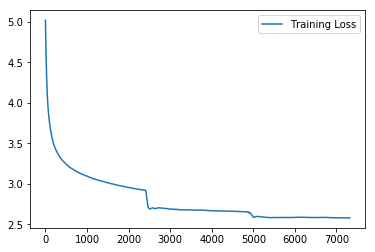

In [12]:
plt.plot(running_mean(lossTrace,50),label='Training Loss')
plt.legend()
plt.show()